<a href="https://colab.research.google.com/github/Miragecore/SandBox/blob/devel/Colab/Stitching_whole_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#드라이브안에서 프로젝트 드라이브로 이동
import os;
root_path = '/content/drive/MyDrive/SandBox/Stitch/earring'

os.chdir(root_path);

print(os.getcwd())

/content/drive/MyDrive/SandBox/Stitch/earring


In [3]:
#from IPython.display import Image, display
import cv2, numpy as np

#Colab에서 imShow를 사용하기 위해 cv2_imshow를 사용한다.
from google.colab.patches import cv2_imshow

#SIFT or SURF는 4.3이상의 버전에서만 사용가능하다. 
if cv2.__version__ != "4.4.0":
  print(cv2.__version__)
  #설치후에는 런타임을 재시작해줘야 한다.
  !pip install opencv-contrib-python==4.4.0.44


In [77]:
#먼저 업로드해둔 이미지 파일들
image_files = [
    'earring_1.jpg',
    'earring_2.jpg',
    'earring_3.jpg']

img1 = cv2.imread(image_files[0])
img2 = cv2.imread(image_files[1])
img3 = cv2.imread(image_files[2])

#cv2_imshow(img1)
#cv2_imshow(img2)
#cv2_imshow(img3)

In [8]:
#원본의 그레이 이미지의 복사본을 리턴
def GetGrayImage(img):
  if len(img.shape) > 2:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else :
    return img.copy()
  

In [78]:
#2장의 이미지를 입력 받아서 keypoint와 변환 매트릭스를 리턴
def FindFeature(img1, img2,detector_type = 'SIFT', mask_enable=False,\
               min_match_count = 10):

  detector = None
  if detector_type == 'ORB':
    detector = cv2.ORB_create()
  if detector_type == 'SIFT':
    detector = cv2.SIFT_create()

  #흑백 이미지 생성
  img1_gray = GetGrayImage(img1)
  img2_gray = GetGrayImage(img2)

  #이미지에서 0인 영역으로 마스크를 생성시켜 계산의 속도 향상, 검은 영역이 없다면 무쓸모
  mask1 = None
  mask2 = None
  if(mask_enable):
    _, mask1 = cv2.threshold(img1_gray, 1, 255, cv2.THRESH_BINARY)
    _, mask2 = cv2.threshold(img2_gray, 1, 255, cv2.THRESH_BINARY)

  #keypoint와 Descriptor 찾기
  kp1, desc1 = detector.detectAndCompute(img1_gray, mask1)
  kp2, desc2 = detector.detectAndCompute(img2_gray, mask2)

  return kp1, desc1, kp2, desc2

In [ ]:
#변환 찾기가 가능한 최소수 4
MIN_MATCH_COUNT = 4

kp1, desc1, kp2, desc2 = FindFeature(img1, img2, \
                                     min_match_count = MIN_MATCH_COUNT)

sift_keypointsIm = cv2.drawKeypoints(img1, kp1, \
                                     outImage = cv2.DRAW_MATCHES_FLAGS_DEFAULT,\
                                     color=(0,0,255))

#cv2_imshow(sift_keypointsIm)

In [80]:
#Descriptor를 비교하여 매치 상태가 좋은 점들만 리턴
def FindGoodMatch(desc1, desc2, matcher_type = 'FLANN', best_match_count = 2, \
          match_dist = 0.7):
  #FLANN MATCHER로 매치 및 굿 피처 필터링

  matcher = None
  if matcher_type == 'FLANN':
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
  if matcher_type == 'BF':
    matcher = cv2.BFMatcher()

  matches = matcher.knnMatch(desc1,desc2,best_match_count)

  # 2번째 후보와 거리가 0.7 이상인 포인트를 좋은 매치로 분류
  good = []
  for m,n in matches:
      if m.distance < match_dist *n.distance:
          good.append(m)

  return good
  

In [81]:
good_matches = FindGoodMatch(desc1, desc2)

if len(good_matches)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])\
    .reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])\
    .reshape(-1,1,2)


#img2 를 img1으로 변환 할 것이기 때문에
M, RANSAC_mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)

In [101]:
#이미지 중앙으로 평행 이동
Mt = np.array([[1,0,2560], [0,1,1920], [0,0,1]],np.float32)

result_img = cv2.warpPerspective(img1,Mt,(5120, 3840))
rg = GetGrayImage(result_img)
_, result_mask = cv2.threshold(rg, 0, 255, cv2.THRESH_BINARY)

In [98]:
#image의 외곽 좌표를 np.array로 리턴
def GetImageCorner(img):
  h, w = img.shape[:2]
  return np.float32([ [0,0],[0,h],[w,h],[w,0]])

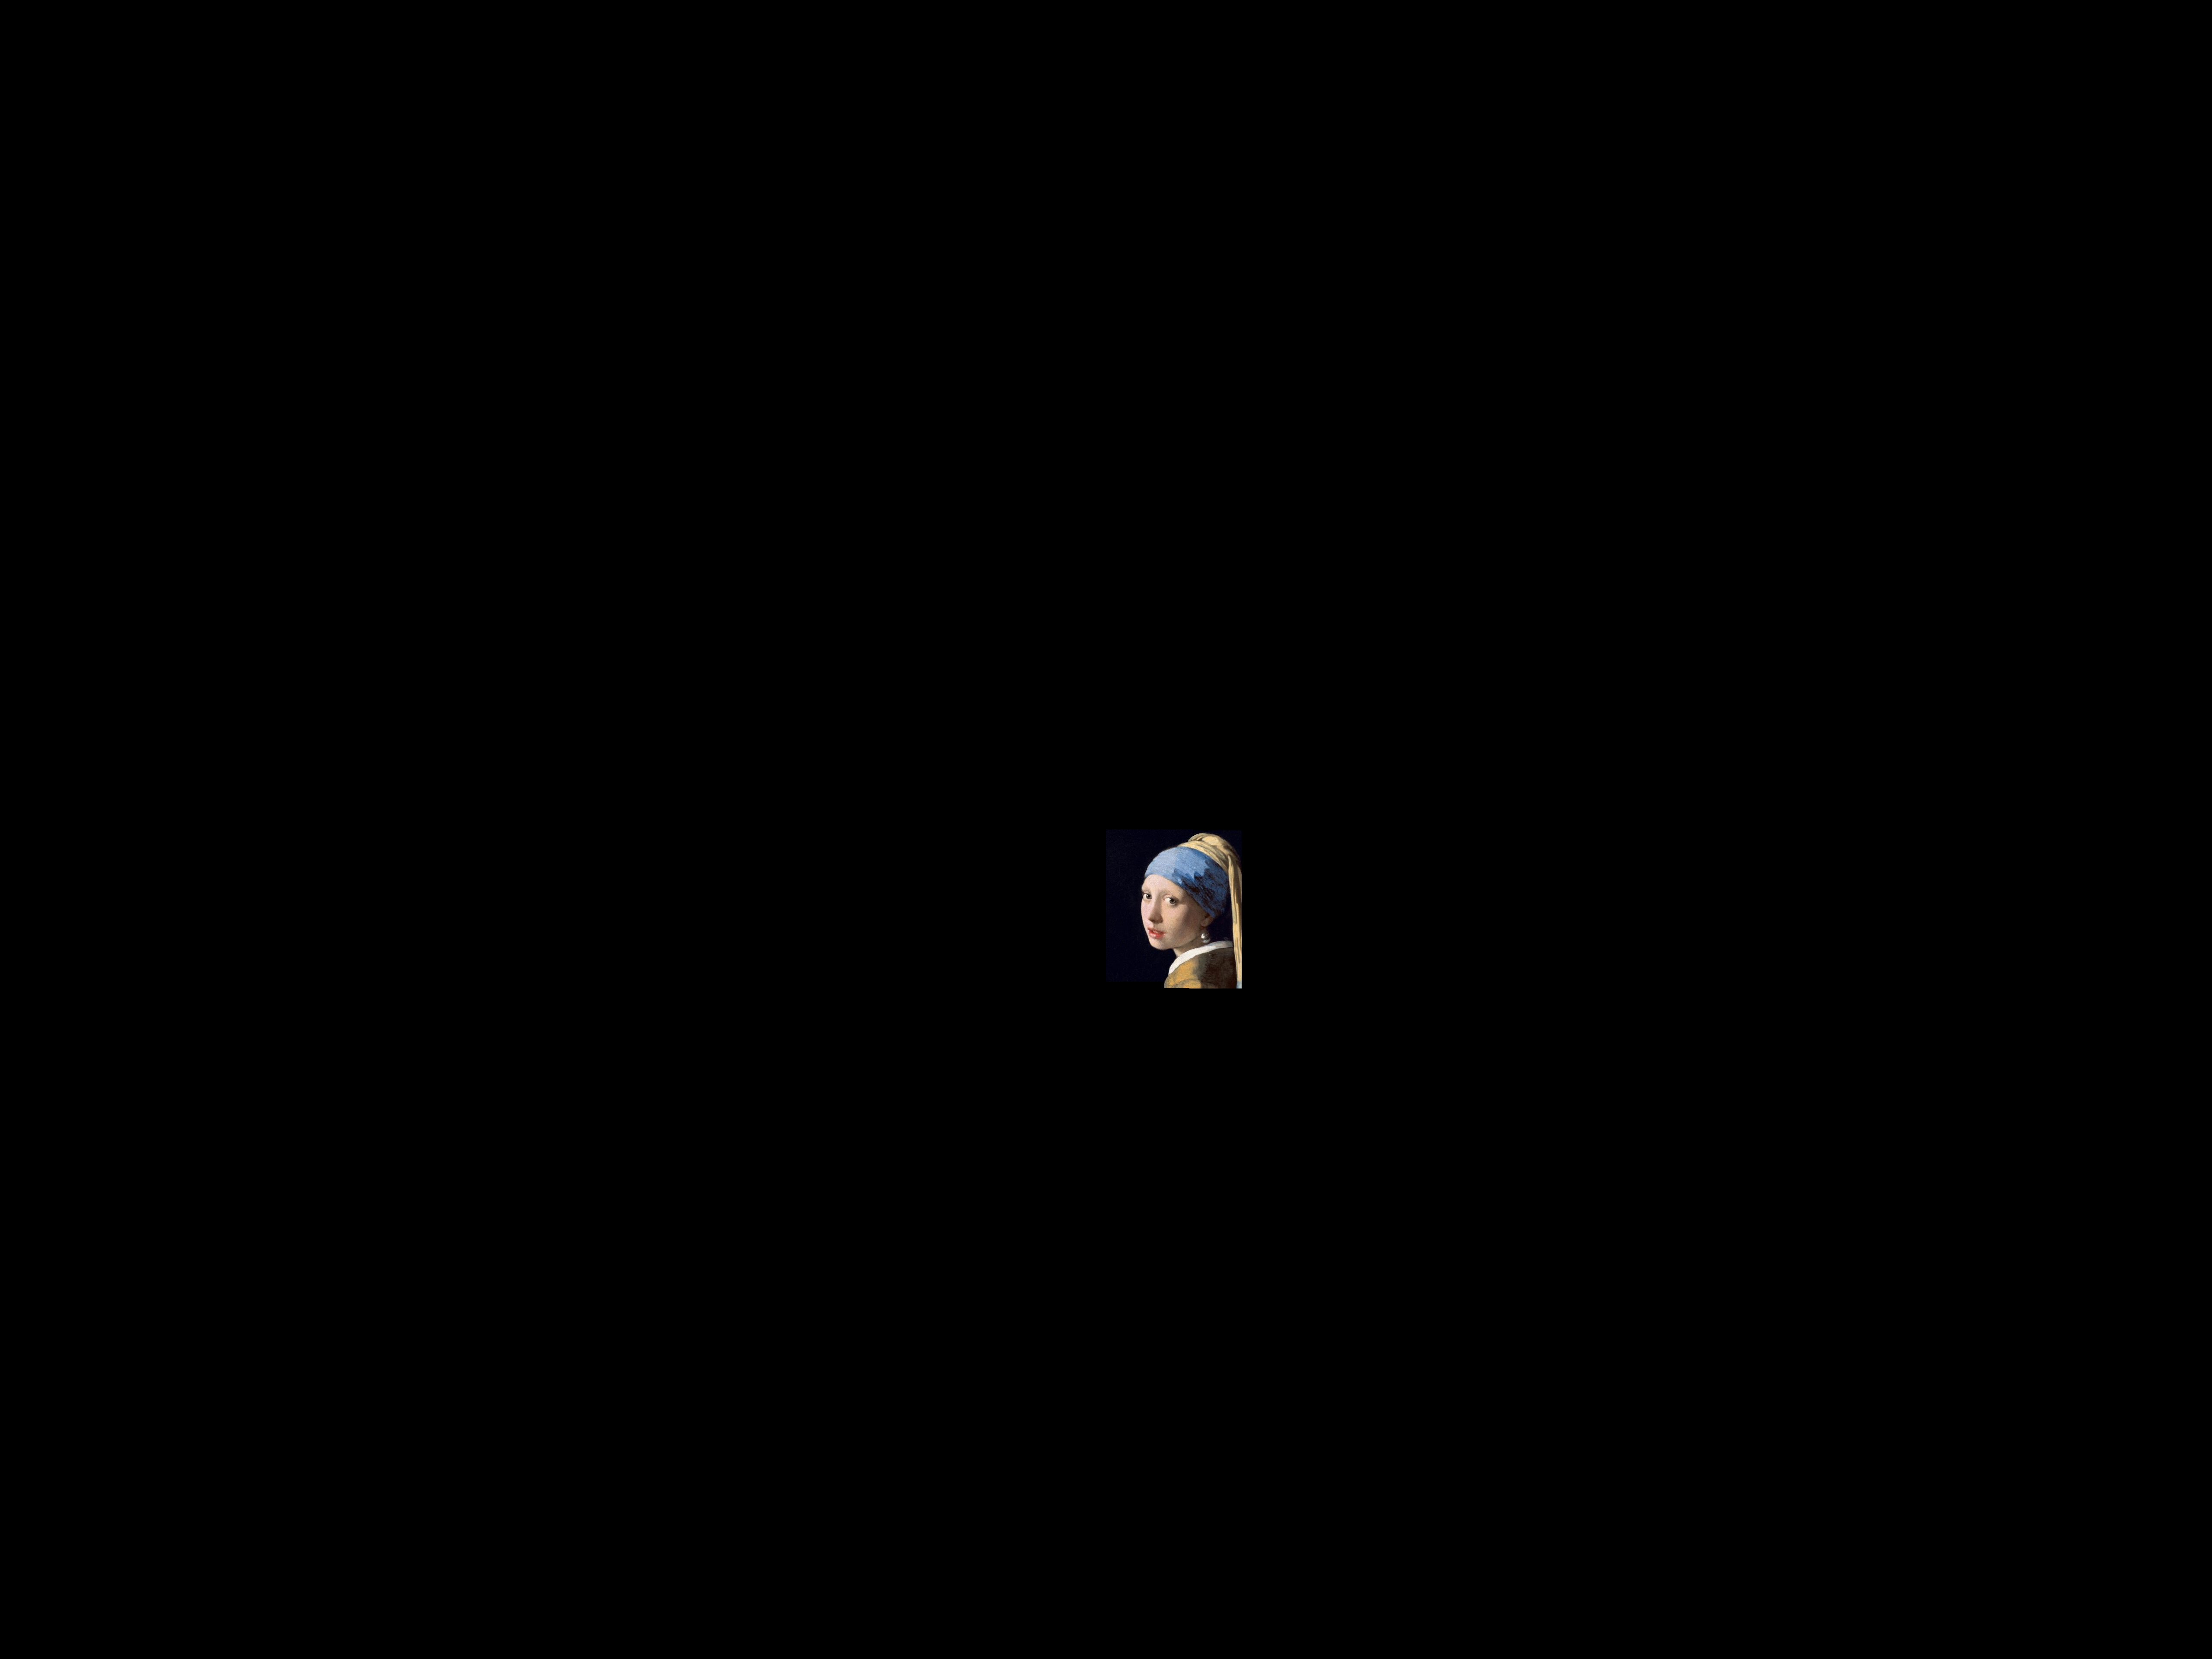

In [102]:
#전체 이미지를 마스킹처리하는 방식
Mt = Mt.dot(M)

warped_img = cv2.warpPerspective(img2, Mt, (5120, 3840))

wg = GetGrayImage(warped_img)
_, warped_mask = cv2.threshold(wg, 1, 255, cv2.THRESH_BINARY)

kernel = np.ones((5,5),np.uint8)
k1 = (kernel == 1).astype('uint8')
warped_mask = cv2.erode(warped_mask, k1, borderType=cv2.BORDER_CONSTANT)

result_mask = cv2.subtract(result_mask, warped_mask)

result_img = cv2.bitwise_or(result_img, result_img, mask=result_mask)

warped_img = cv2.bitwise_and(warped_img, warped_img, mask=warped_mask)

result_img = cv2.add(warped_img, result_img)

result_mask = cv2.add(result_mask, warped_mask)

cv2_imshow(result_img)